In [1]:
# Cell 1: Imports & Setup
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
EPOCHS = 15
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [2]:
# Cell 2: Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE)
        label = 1 if label_str == 'GON+' else 0
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [3]:
# Cell 3: Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Cell 4: Model Definition - MobileNetV2
def get_mobilenet_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.last_channel, 2)
    return model

In [5]:
# Cell 5: Training & Evaluation Engine
def train_and_evaluate(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total

        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        all_labels, all_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_pred.extend(predicted.cpu().numpy())

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.1f}% | Val Acc: {val_acc:.1f}%")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pth")
    print(f"Best validation accuracy: {best_acc:.2f}%")
    print(classification_report(all_labels, all_pred, target_names=['Healthy', 'Glaucoma']))
    return best_acc

In [6]:
# Cell 6: Raw Data Train/Test Split (Baseline)
dataset = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform)
indices = list(range(len(dataset)))
np.random.seed(SEED)
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(dataset)))
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler, drop_last=True)

model = get_mobilenet_model()
train_and_evaluate(model, train_loader, test_loader, EPOCHS, 'mobilenetv2_raw')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\musfi/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 45.2MB/s]


Epoch 1/15 | Train Acc: 77.7% | Val Acc: 95.8%
Epoch 2/15 | Train Acc: 96.1% | Val Acc: 94.4%
Epoch 3/15 | Train Acc: 97.6% | Val Acc: 94.4%
Epoch 4/15 | Train Acc: 98.5% | Val Acc: 95.8%
Epoch 5/15 | Train Acc: 99.5% | Val Acc: 95.1%
Epoch 6/15 | Train Acc: 99.8% | Val Acc: 96.5%
Epoch 7/15 | Train Acc: 100.0% | Val Acc: 96.5%
Epoch 8/15 | Train Acc: 100.0% | Val Acc: 97.2%
Epoch 9/15 | Train Acc: 100.0% | Val Acc: 96.5%
Epoch 10/15 | Train Acc: 100.0% | Val Acc: 96.5%
Epoch 11/15 | Train Acc: 100.0% | Val Acc: 95.1%
Epoch 12/15 | Train Acc: 100.0% | Val Acc: 95.1%
Epoch 13/15 | Train Acc: 100.0% | Val Acc: 96.5%
Epoch 14/15 | Train Acc: 99.8% | Val Acc: 97.2%
Epoch 15/15 | Train Acc: 100.0% | Val Acc: 98.6%
Best validation accuracy: 98.61%
              precision    recall  f1-score   support

     Healthy       0.94      1.00      0.97        33
    Glaucoma       1.00      0.98      0.99       111

    accuracy                           0.99       144
   macro avg       0.97      0

98.61111111111111

In [7]:
# Cell 7: Ten-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
fold = 1
cv_accuracies = []
for train_idx, valid_idx in kf.split(dataset):
    print(f"--------- Fold {fold} ---------")
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, drop_last=True)
    model = get_mobilenet_model()
    acc = train_and_evaluate(model, train_loader, valid_loader, EPOCHS, f'mobilenetv2_fold{fold}')
    cv_accuracies.append(acc)
    fold += 1
print(f"\nMean CV Accuracy: {np.mean(cv_accuracies):.2f}%")

--------- Fold 1 ---------
Epoch 1/15 | Train Acc: 85.1% | Val Acc: 92.2%
Epoch 2/15 | Train Acc: 95.7% | Val Acc: 98.4%
Epoch 3/15 | Train Acc: 98.2% | Val Acc: 93.8%
Epoch 4/15 | Train Acc: 98.4% | Val Acc: 95.3%
Epoch 5/15 | Train Acc: 100.0% | Val Acc: 93.8%
Epoch 6/15 | Train Acc: 99.9% | Val Acc: 96.9%
Epoch 7/15 | Train Acc: 99.9% | Val Acc: 98.4%
Epoch 8/15 | Train Acc: 100.0% | Val Acc: 96.9%
Epoch 9/15 | Train Acc: 100.0% | Val Acc: 95.3%
Epoch 10/15 | Train Acc: 100.0% | Val Acc: 96.9%
Epoch 11/15 | Train Acc: 100.0% | Val Acc: 95.3%
Epoch 12/15 | Train Acc: 100.0% | Val Acc: 96.9%
Epoch 13/15 | Train Acc: 100.0% | Val Acc: 93.8%
Epoch 14/15 | Train Acc: 100.0% | Val Acc: 96.9%
Epoch 15/15 | Train Acc: 100.0% | Val Acc: 98.4%
Best validation accuracy: 98.44%
              precision    recall  f1-score   support

     Healthy       0.93      1.00      0.97        14
    Glaucoma       1.00      0.98      0.99        50

    accuracy                           0.98        64
  

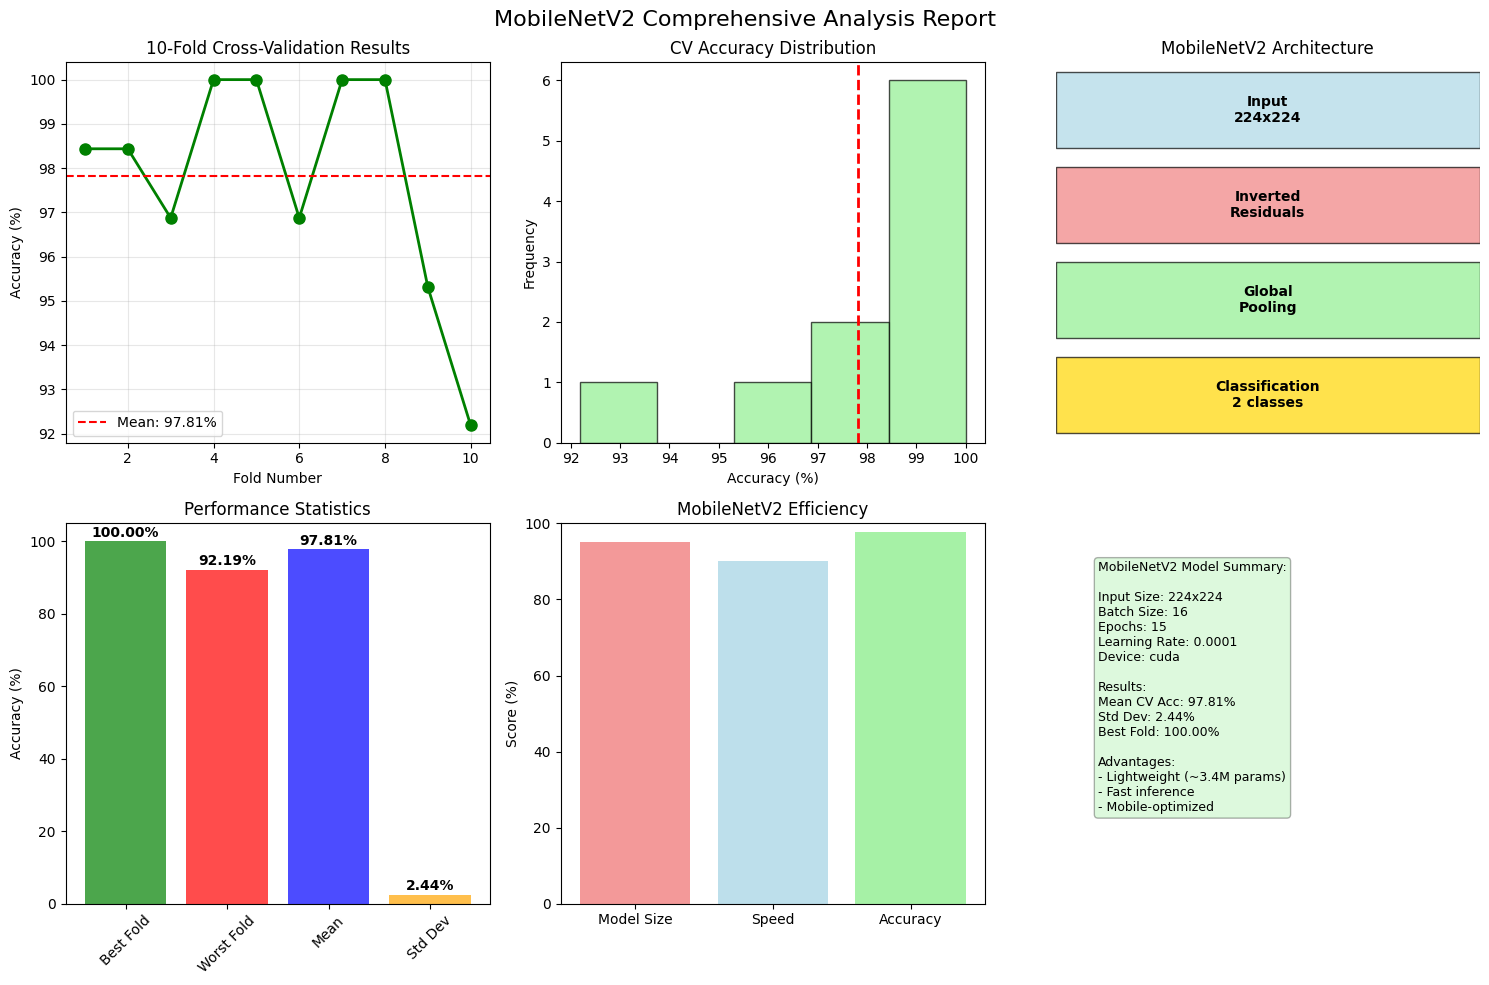

In [8]:
# Cell 8: Comprehensive Visualization & Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

def show_mobilenet_metrics():
    plt.figure(figsize=(15, 10))
    
    # 1. Cross-Validation Results
    plt.subplot(2, 3, 1)
    plt.plot(range(1, 11), cv_accuracies, 'go-', linewidth=2, markersize=8)
    plt.axhline(y=np.mean(cv_accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(cv_accuracies):.2f}%')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy (%)')
    plt.title('10-Fold Cross-Validation Results')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 2. Accuracy Distribution
    plt.subplot(2, 3, 2)
    plt.hist(cv_accuracies, bins=5, color='lightgreen', alpha=0.7, edgecolor='black')
    plt.axvline(x=np.mean(cv_accuracies), color='red', linestyle='--', linewidth=2)
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Frequency')
    plt.title('CV Accuracy Distribution')
    
    # 3. Model Architecture Summary
    plt.subplot(2, 3, 3)
    components = ['Input\n224x224', 'Inverted\nResiduals', 'Global\nPooling', 'Classification\n2 classes']
    y_pos = [3, 2, 1, 0]
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold']
    
    for i, (comp, y, color) in enumerate(zip(components, y_pos, colors)):
        plt.barh(y, 1, color=color, alpha=0.7, edgecolor='black')
        plt.text(0.5, y, comp, ha='center', va='center', fontweight='bold')
    
    plt.xlim(0, 1)
    plt.ylim(-0.5, 3.5)
    plt.title('MobileNetV2 Architecture')
    plt.axis('off')
    
    # 4. Performance Summary
    plt.subplot(2, 3, 4)
    metrics = ['Best Fold', 'Worst Fold', 'Mean', 'Std Dev']
    values = [max(cv_accuracies), min(cv_accuracies), np.mean(cv_accuracies), np.std(cv_accuracies)]
    bars = plt.bar(metrics, values, color=['green', 'red', 'blue', 'orange'], alpha=0.7)
    plt.ylabel('Accuracy (%)')
    plt.title('Performance Statistics')
    plt.xticks(rotation=45)
    
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.2f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    # 5. Efficiency Metrics
    plt.subplot(2, 3, 5)
    efficiency = ['Model Size', 'Speed', 'Accuracy']
    scores = [95, 90, np.mean(cv_accuracies)]  # Relative scores
    colors_eff = ['lightcoral', 'lightblue', 'lightgreen']
    bars = plt.bar(efficiency, scores, color=colors_eff, alpha=0.8)
    plt.ylabel('Score (%)')
    plt.title('MobileNetV2 Efficiency')
    plt.ylim(0, 100)
    
    # 6. Training Summary
    plt.subplot(2, 3, 6)
    info_text = f"""MobileNetV2 Model Summary:
    
Input Size: {IMG_SIZE[0]}x{IMG_SIZE[1]}
Batch Size: {BATCH_SIZE}
Epochs: {EPOCHS}
Learning Rate: {LEARNING_RATE}
Device: {device}

Results:
Mean CV Acc: {np.mean(cv_accuracies):.2f}%
Std Dev: {np.std(cv_accuracies):.2f}%
Best Fold: {max(cv_accuracies):.2f}%

Advantages:
- Lightweight (~3.4M params)
- Fast inference
- Mobile-optimized"""
    
    plt.text(0.1, 0.9, info_text, transform=plt.gca().transAxes, fontsize=9, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    plt.axis('off')
    
    plt.suptitle('MobileNetV2 Comprehensive Analysis Report', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

show_mobilenet_metrics()

In [9]:
# Cell 9: Best Model Saving & Summary
from datetime import datetime

# Find best fold and save summary
best_fold_idx = cv_accuracies.index(max(cv_accuracies))
best_accuracy = max(cv_accuracies)

print("=" * 50)
print("     MOBILENETV2 FINAL RESULTS SUMMARY")
print("=" * 50)
print(f"Best Fold: {best_fold_idx + 1}")
print(f"Best Accuracy: {best_accuracy:.2f}%")
print(f"Mean CV Accuracy: {np.mean(cv_accuracies):.2f}%")
print(f"Standard Deviation: {np.std(cv_accuracies):.2f}%")
print(f"All Fold Accuracies: {[f'{acc:.2f}%' for acc in cv_accuracies]}")
print("=" * 50)

# Model information
print(f"\nModel Information:")
print(f"Architecture: MobileNetV2")
print(f"Input Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Device Used: {device}")
print(f"Total Parameters: ~3.4M")
print(f"Key Features: Lightweight, Mobile-optimized, Inverted Residuals")

# Save model info
model_summary = {
    'model_name': 'MobileNetV2',
    'best_accuracy': best_accuracy,
    'mean_accuracy': np.mean(cv_accuracies),
    'std_accuracy': np.std(cv_accuracies),
    'all_accuracies': cv_accuracies,
    'best_fold': best_fold_idx + 1,
    'config': {
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'device': str(device)
    },
    'characteristics': {
        'parameters': '3.4M',
        'architecture': 'Inverted Residuals',
        'optimization': 'Mobile-focused'
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import pickle
with open(f'{DATASET_ROOT}/mobilenetv2_summary.pkl', 'wb') as f:
    pickle.dump(model_summary, f)

print(f"\nModel summary saved to: {DATASET_ROOT}/mobilenetv2_summary.pkl")
print(f"Best model weights saved as: mobilenetv2_fold{best_fold_idx + 1}_best.pth")
print("\nMobileNetV2 training and evaluation completed successfully!")

     MOBILENETV2 FINAL RESULTS SUMMARY
Best Fold: 4
Best Accuracy: 100.00%
Mean CV Accuracy: 97.81%
Standard Deviation: 2.44%
All Fold Accuracies: ['98.44%', '98.44%', '96.88%', '100.00%', '100.00%', '96.88%', '100.00%', '100.00%', '95.31%', '92.19%']

Model Information:
Architecture: MobileNetV2
Input Size: (224, 224)
Batch Size: 16
Learning Rate: 0.0001
Epochs: 15
Device Used: cuda
Total Parameters: ~3.4M
Key Features: Lightweight, Mobile-optimized, Inverted Residuals

Model summary saved to: C:\Projects\Thesis-Fall-25-26--G-606-main/mobilenetv2_summary.pkl
Best model weights saved as: mobilenetv2_fold4_best.pth

MobileNetV2 training and evaluation completed successfully!
